In [1]:
import pandas as pd
import numpy as np
import tqdm
import torch

# Pre processing

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool

class EdgeNet(nn.Module):
    def __init__(self, input_dim=4, big_dim=32, hidden_dim=2, aggr='mean'):
        super(EdgeNet, self).__init__()
        encoder_nn = nn.Sequential(nn.Linear(2*(input_dim), big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, hidden_dim),
                               nn.ReLU(),
        )
        
        decoder_nn = nn.Sequential(nn.Linear(2*(hidden_dim), big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, big_dim),
                               nn.ReLU(),
                               nn.Linear(big_dim, input_dim)
        )
        
        self.batchnorm = nn.BatchNorm1d(input_dim)

        self.encoder = EdgeConv(nn=encoder_nn,aggr=aggr)
        self.decoder = EdgeConv(nn=decoder_nn,aggr=aggr)

    def forward(self, data):
        data.x = self.batchnorm(data.x)
        data.x = self.encoder(data.x,data.edge_index)
        data.x = self.decoder(data.x,data.edge_index)
        return data.x

In [3]:
import torch
from torch_geometric.data import Data, DataLoader
import os
import os.path as osp
import math
import argparse
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from graph_data import GraphDataset

gdata = GraphDataset(root='/anomalyvol/data/')

input_dim = 4
big_dim = 32
hidden_dim = 2
fulllen = len(gdata)
tv_frac = 0.10
tv_num = math.ceil(fulllen*tv_frac)
splits = np.cumsum([fulllen-2*tv_num,tv_num,tv_num])
batch_size = 512
n_epochs = 1
lr = 0.001
patience = 10
device = 'cuda:0'
model_fname = 'EdgeNet'

model = EdgeNet(input_dim=input_dim, big_dim=big_dim, hidden_dim=hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [4]:
train_dataset = GraphDataset(root='/anomalyvol/data/',start=0,stop=splits[0])
valid_dataset = GraphDataset(root='/anomalyvol/data/',start=splits[1],stop=splits[2])
test_dataset = GraphDataset(root='/anomalyvol/data/',start=splits[0 ],stop=splits[1])

train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)

print(train_samples)
print(valid_samples)
print(test_samples)

24043
2405
2405


In [5]:
@torch.no_grad()
def test(model,loader,total,batch_size):
    model.eval()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        batch_output = model(data)
        batch_loss_item = mse(batch_output, data.y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size):
    model.train()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        optimizer.zero_grad()
        batch_output = model(data)
        batch_loss = mse(batch_output, data.y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [6]:
n_epochs = 50
modpath = osp.join('/anomalyvol/models/gnn/',model_fname+'.best.pth')

In [ ]:
stale_epochs = 0
best_valid_loss = 99999
for epoch in range(0, n_epochs):
    loss = train(model, optimizer, train_loader, train_samples, batch_size)
    valid_loss = test(model, valid_loader, valid_samples, batch_size)
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('               Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('/anomalyvol/models/gnn/',model_fname+'.best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

In [7]:
model.load_state_dict(torch.load(modpath))
input_x = []
output_x = []

t = tqdm.tqdm(enumerate(test_loader),total=test_samples/batch_size)
for i, data in t:
    data.to(device)
    input_x.append(data.x.cpu().numpy())
    output_x.append(model(data).cpu().detach().numpy())

 85%|████████▌ | 4/4.697265625 [01:46<00:18, 26.97s/it]/opt/conda/lib/python3.7/site-packages/tqdm/std.py:484: TqdmWarning: clamping frac to range [0, 1]
  charset=Bar.ASCII if ascii is True else ascii or Bar.UTF)
106%|██████████| 5/4.697265625 [02:03<-1:59:53, 24.74s/it]


(134117,)
(134117,)
px


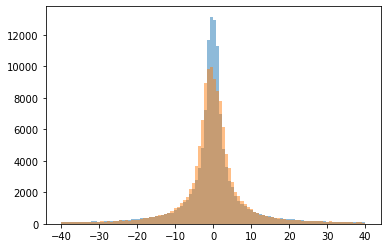

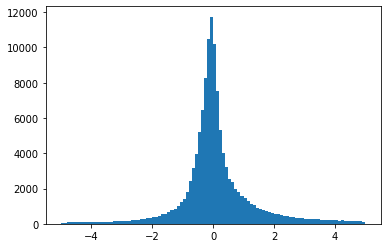

py


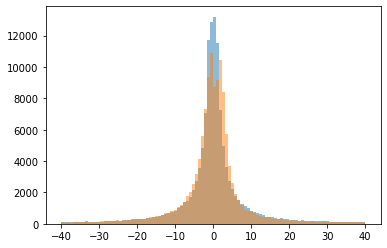

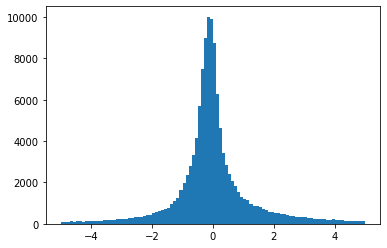

pz


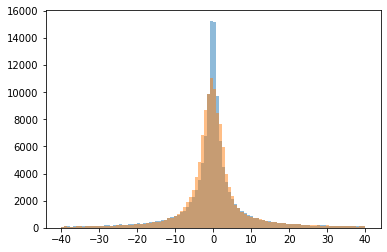

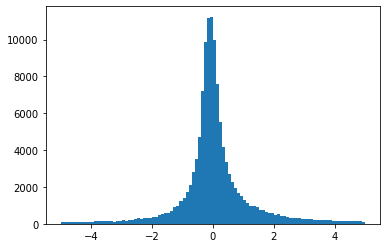

e


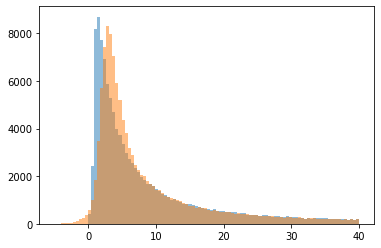

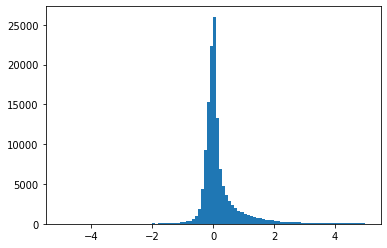

In [17]:
diff_px = []
output_px = []
input_px = []
diff_py = []
output_py = []
input_py = []
diff_pz = []
output_pz = []
input_pz = []
diff_e = []
output_e = []
input_e = []

for i in range(len(input_x)):
    ft_idx = 0
    diff_px.append(((output_x[i][:,ft_idx]-input_x[i][:,ft_idx])/input_x[i][:,ft_idx]).flatten())
    output_px.append(output_x[i][:,ft_idx].flatten())
    input_px.append(input_x[i][:,ft_idx].flatten())
    ft_idx = 1
    diff_py.append(((output_x[i][:,ft_idx]-input_x[i][:,ft_idx])/input_x[i][:,ft_idx]).flatten())
    output_py.append(output_x[i][:,ft_idx].flatten())
    input_py.append(input_x[i][:,ft_idx].flatten())
    ft_idx = 2
    diff_pz.append(((output_x[i][:,ft_idx]-input_x[i][:,ft_idx])/input_x[i][:,ft_idx]).flatten())
    output_pz.append(output_x[i][:,ft_idx].flatten())
    input_pz.append(input_x[i][:,ft_idx].flatten())
    ft_idx = 3
    diff_e.append(((output_x[i][:,ft_idx]-input_x[i][:,ft_idx])/input_x[i][:,ft_idx]).flatten())
    output_e.append(output_x[i][:,ft_idx].flatten())
    input_e.append(input_x[i][:,ft_idx].flatten())

all_diff_px = np.concatenate(diff_px)
all_input_px = np.concatenate(input_px)
all_output_px = np.concatenate(output_px)
all_diff_py = np.concatenate(diff_py)
all_input_py = np.concatenate(input_py)
all_output_py = np.concatenate(output_py)
all_diff_pz = np.concatenate(diff_pz)
all_input_pz = np.concatenate(input_pz)
all_output_pz = np.concatenate(output_pz)
all_diff_e = np.concatenate(diff_e)
all_input_e = np.concatenate(input_e)
all_output_e = np.concatenate(output_e)

print(all_input_px.shape)
print(all_output_px.shape)

print("px")

bins = np.linspace(-40, 40, 101)

plt.figure()
plt.hist(all_input_px, bins=bins,alpha=0.5)
plt.hist(all_output_px, bins=bins,alpha=0.5)
plt.show()

plt.figure()
plt.hist(all_diff_px, bins=np.linspace(-5, 5, 101))
plt.show()

print("py")

plt.figure()
plt.hist(all_input_py, bins=bins,alpha=0.5)
plt.hist(all_output_py, bins=bins,alpha=0.5)
plt.show()

plt.figure()
plt.hist(all_diff_py, bins=np.linspace(-5, 5, 101))
plt.show()

print("pz")

plt.figure()
plt.hist(all_input_pz, bins=bins,alpha=0.5)
plt.hist(all_output_pz, bins=bins,alpha=0.5)
plt.show()

plt.figure()
plt.hist(all_diff_pz, bins=np.linspace(-5, 5, 101))
plt.show()

print("e")

bins = np.linspace(-5, 40, 101)

plt.figure()
plt.hist(all_input_e, bins=bins,alpha=0.5)
plt.hist(all_output_e, bins=bins,alpha=0.5)
plt.show()

plt.figure()
plt.hist(all_diff_e, bins=np.linspace(-5, 5, 101))
plt.show()